In [19]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
import math
import time
%matplotlib inline

In [20]:
class Network(object):
    
    def __init__(self, layer_node): #layer_node is a list contains the number of nodes in each layer
        self.num_layer = len(layer_node)
        self.layer_node = layer_node
        self.input_node = []
        #self.node = [ np.random.randn(num_node,1) for num_node in layer_node ]
        self.weights = [ np.random.randn(next_node,previous_node+1) for next_node, previous_node in zip(layer_node[1:],layer_node[:-1]) ]
        
    def add_input_node(self,input_vector): #must be of size (n,1)
        if len(input_vector) == self.layer_node[0]: 
            self.input_node = np.append([[1]],input_vector, axis=0) # add bias node
        else:
            print "Input vector length invalid: given len {1}, need len {0}".format(self.layer_node[0], len(input_vector))
            
    def forward_propagation(self):
        output_value = self.input_node
        for weight in self.weights: 
            #print weight.shape
            #print output_vector.shape
            s = np.dot(weight, output_value)
            #print "forward"
            output_value = np.append([[1]], activation_function(s), axis=0) # add bias node -> size (n+1,1)
        #print "out:",output_vector
        #print output_value[1:][0][0]
        return np.sign(output_value[1:][0][0]) # we omit the bias node 
        
    def backpropagation(self,input_vector, output_vector):
        s = [] # vector before entering node
        x = [np.append([[1]],input_vector, axis=0)] # vector after entering node
        sensitivity = [ np.zeros([1,i]) for i in self.layer_node[1:] ]
        #print len(sensitivity)
        
        #feedforward, save all the node coefs of each layer
        for weight in self.weights:
            s.append(np.dot(weight, x[-1]))
            #print "back"
            x.append(np.append([[1]], activation_function(s[-1]), axis=0))
        #print x[-1][1:]
        #print np.square(x[-1][1:])
        sensitivity[-1] = 2.0*(x[-1][1:] - output_vector)*(1-np.square(x[-1][1:])) # omit the bias node 
        
        #backpropagation, compute sensitivity backward
        for layer_index in xrange(2, self.num_layer):
            w = self.weights[-layer_index+1]
            #print w
            #print w.shape
            #print sensitivity[-layer_index+1].shape
            
            sensitivity[-layer_index] = (1-np.square(x[-layer_index][1:]))*(np.dot(w.T,sensitivity[-layer_index+1]))[1:] #excluding the bias componnent which has the index 0
            
        return x, sensitivity
    
    def SGD(self, training_data, testing_data, eta, epochs): #stochastic gradient descent
        error_ratio_list = []
        error_ratio = 0
        error_count = 0
        predicted_result = []
        
        for epoch in xrange(epochs): 
            gradient = [np.zeros(w.shape) for w in self.weights]
            #gradient = [ np.random.randn(next_node,previous_node+1) 
                            #for next_node, previous_node in zip(self.layer_node[1:],self.layer_node[:-1])]
            for index, row in training_data.iterrows():
                vector = np.array(row).reshape(3,1) 
                input_vector, output_vector = vector[:2], vector[2:]
                x, sensitivity = self.backpropagation(input_vector, output_vector)
                
                #print "sens ", len(sensitivity)
                #print "x ", len(x)
                #break
                
                for l in xrange(len(gradient)):
                    #print x[l].shape
                    #print sensitivity[l].shape
                    gradient[l] = np.dot(sensitivity[l],np.transpose(x[l]))
                    self.weights[l] = self.weights[l] - eta*gradient[l]
           
            #print "epoch ",epoch+1
            
            error_ratio, error_count, predicted_result = self.evaluate(testing_data)
            error_ratio_list.append(error_ratio)
     
            #print "Epoch {0}: MSE = {1}".format(epoch+1, MSE)
            #print
        
        print "Error = {0}/{1}".format(error_count[0,0], testing_data.shape[0])
        print "Error ratio = ", error_ratio_list[-1]
        data = visualization(testing_data, error_ratio_list, predicted_result)
        
        return error_ratio_list, predicted_result, data
    
    
    
    def evaluate(self,testing_data):
        error_count = 0
        predicted_result = []
        for index, row in testing_data.iterrows():
            vector = np.array(row).reshape(3,1) 
            input_vector, output_vector = vector[:2], vector[2:]
            self.add_input_node(input_vector)
            predicted_value = self.forward_propagation()
            #print type(predicted_value)
            predicted_result.append(predicted_value)
            #print predicted_vector, output_vector
            #print "decision :", predicted_vector != output_vector
            error_count += predicted_value != output_vector #np.abs(predicted_vector - output_vector)
            #print predicted_value
        return float(error_count)/testing_data.shape[0], error_count, predicted_result

            

In [21]:
def visualization(df, MSE, predicted_result): 
    data = df.copy()
    data['Predicted'] = predicted_result

    plt.figure(1)
    plt.plot(MSE)
    plt.title("Error Ratio Plot")
    
    colormap = np.array(['b','b' ,'r'])
    
    plt.figure(2)
    plt.scatter(data.x, data.y, c=colormap[data.Class], s=40)
    plt.title("True Plot")
    
    plt.figure(3)
    plt.scatter(data.x, data.y, c=colormap[data.Predicted], s=40)
    plt.title("Predicted Plot")
    
    plt.show()
    
    return data

In [22]:
def activation_function(z): 
    return np.tanh(z) # sigmoid function tanh

Create dataframe

In [23]:
def str_to_float(df): 
    new_df = df.copy()
    return new_df.applymap(lambda x: float(x.replace(',','.')))

In [24]:
def z_score(df):
    new_df = df.copy()
    new_df.x = (new_df.x - new_df.x.mean())/new_df.x.std(ddof=0)
    new_df.y = (new_df.y - new_df.y.mean())/new_df.y.std(ddof=0)
    return new_df

In [25]:
df = pd.read_csv('donneespb4.txt',sep=' ',header=None)
df.columns = ['x','y','Value']
df = str_to_float(df)
df = z_score(df) 
binary_code = [np.sign(x-.5) for x in df.Value] 
df['Class'] = binary_code 
df = df.drop('Value',1)
df.head()

,x,y,Class
0,1.064435,-1.267294,1
1,-1.016185,-0.788290,-1
2,-1.056870,-0.637423,-1
3,-1.011227,0.242393,-1
4,0.067787,1.517892,1


In [26]:
train = df.iloc[:2700]
test = df.iloc[2700:]

C:\Users\tphan\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
C:\Users\tphan\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


Error = 2/3000
Error ratio =  0.000666666666667


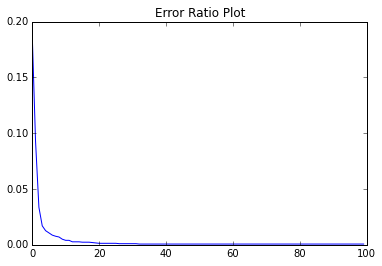

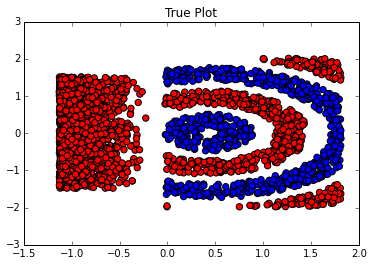

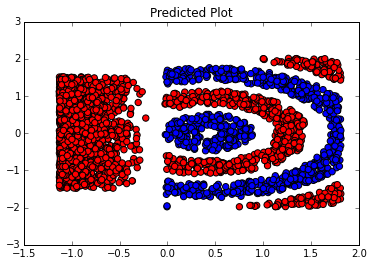

Processing time: 82.2484892043 seconds


In [27]:
net = Network([2,30,1])
t0 = time.clock()
MSE, predicted_result, data = net.SGD(df,df,0.01,100)
print "Processing time: {0} seconds".format((time.clock() - t0))